<a href="https://colab.research.google.com/github/ppfenninger/Sensorimotor_Learning_Final/blob/main/Sensorimotor_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
## Installation
!pip install pybullet > /dev/null 2>&1
!pip install git+https://github.com/taochenshh/easyrl.git > /dev/null 2>&1
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!pip install git+https://github.com/ppfenninger/airobot.git > /dev/null 2>&1
# !pip install git+https://github.com/ppfenninger/Sensorimotor_Learning_Final.git > /dev/null 2>&1

In [4]:
import os
import torch
import gym
import pprint
import time
import pybullet as p
import pybullet_data as pd
import pybullet_envs
import airobot as ar
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim
import torch.nn.functional as F
from typing import Any
from matplotlib import animation
from IPython.display import HTML
from matplotlib import pylab
from dataclasses import dataclass
from gym import spaces
from gym.envs.registration import registry, register
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
from tqdm.notebook import tqdm
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from pathlib import Path
from copy import deepcopy
from itertools import count
from easyrl.agents.ppo_agent import PPOAgent
from easyrl.utils.common import save_traj
from easyrl.configs import cfg
from easyrl.configs import set_config
from easyrl.configs.command_line import cfg_from_cmd
from easyrl.engine.ppo_engine import PPOEngine
from easyrl.models.categorical_policy import CategoricalPolicy
from easyrl.models.diag_gaussian_policy import DiagGaussianPolicy
from easyrl.models.mlp import MLP
from easyrl.models.value_net import ValueNet
from easyrl.agents.base_agent import BaseAgent
from easyrl.utils.torch_util import DictDataset
from easyrl.utils.torch_util import load_state_dict
from easyrl.utils.torch_util import load_torch_model
from easyrl.runner.nstep_runner import EpisodicRunner
from easyrl.utils.torch_util import save_model
from easyrl.utils.torch_util import action_entropy
from easyrl.utils.torch_util import action_from_dist
from easyrl.utils.torch_util import action_log_prob
from easyrl.utils.torch_util import clip_grad
from easyrl.utils.common import set_random_seed
from easyrl.utils.gym_util import make_vec_env
from easyrl.utils.common import load_from_json
from easyrl.utils.torch_util import freeze_model
from easyrl.utils.torch_util import move_to
from easyrl.utils.torch_util import torch_float
from easyrl.utils.torch_util import torch_to_np
from base64 import b64encode
from IPython import display as ipythondisplay

/usr/local/lib/python3.10/dist-packages/gym/envs/registration.py:440: UserWarning: WARN: The `registry.env_specs` property along with `EnvSpecTree` is deprecated. Please use `registry` directly as a dictionary instead.
  logger.warn(


In [5]:
# install our library
!rm Sensorimotor_Learning_Final -r
!git clone  https://github.com/ppfenninger/Sensorimotor_Learning_Final.git > /dev/null 2>&1
import sys
sys.path.insert(0, './Sensorimotor_Learning_Final/deepexploration/')
# import de_agent
# import de_engine
# import de_runner # this should work once everything compiles
import utils
from utils import generate_demonstration_data, eval_agent, load_expert_agent

# Environment Setup

In [6]:
class URRobotPusherGym(gym.Env):
    def __init__(self,
                 action_repeat=10,
                 gui=False,
                 max_episode_length=30,
                 dist_threshold=0.05):
        self._action_repeat = action_repeat
        self._max_episode_length = max_episode_length
        self._dist_threshold = dist_threshold

        self._xy_bounds = np.array([[0.23, 0.78],  # [xmin, xmax]
                                    [-0.35, 0.3]])  # [ymin, ymax]
        self._goal_bounds = np.array([[0.3, 0.65],  # [xmin, xmax]
                                      [0.0, 0.25]])  # [ymin, ymax]
        self.robot = ar.Robot('ur5e_stick',
                           pb_cfg={'gui': gui,
                                   'realtime': False,
                                   'opengl_render': torch.cuda.is_available()})
        self._arm_reset_pos = np.array([-0.38337763,
                                        -2.02650575,
                                        -2.01989619,
                                        -0.64477803,
                                        1.571439041,
                                        -0.38331266])
        self._table_id = self.robot.pb_client.load_urdf('table/table.urdf',
                                                        [.5, 0, 0.4],
                                                        ar.utils.common.euler2quat([0, 0, np.pi / 2]),
                                                        scaling=0.9)

        # create a ball at the start location (for visualization purpose)
        self._start_pos = np.array([0.45, -0.32, 1.0])
        self._start_urdf_id = self.robot.pb_client.load_geom('sphere', size=0.04, mass=0,
                                                             base_pos=self._start_pos,
                                                             rgba=[1, 1, 0, 0.8])

        # create a ball at the goal location
        self._goal_pos = np.array([0.5, 0.2, 1.0])
        self._goal_urdf_id = self.robot.pb_client.load_geom('sphere', size=0.04, mass=0,
                                                            base_pos=self._goal_pos,
                                                            rgba=[1, 0, 0, 0.8])

        # disable the collision checking between the robot and the ball at the goal location
        for i in range(self.robot.pb_client.getNumJoints(self.robot.arm.robot_id)):
            self.robot.pb_client.setCollisionFilterPair(self.robot.arm.robot_id,
                                                        self._goal_urdf_id,
                                                        i,
                                                        -1,
                                                        enableCollision=0)
        # disable the collision checking between the robot and the ball at the start location
        for i in range(self.robot.pb_client.getNumJoints(self.robot.arm.robot_id)):
            self.robot.pb_client.setCollisionFilterPair(self.robot.arm.robot_id,
                                                        self._start_urdf_id,
                                                        i,
                                                        -1,
                                                        enableCollision=0)

        self._box_pos = np.array([0.45, -0.1, 0.996])
        self._box_id = self.robot.pb_client.load_geom('cylinder', size=[0.05, 0.05], mass=1.,
                                                      base_pos=self._box_pos,
                                                      rgba=[1., 0.6, 0.6, 1])

        self.robot.pb_client.changeDynamics(self._box_id, -1, lateralFriction=0.9)

        self.robot.pb_client.setCollisionFilterPair(self._box_id,
                                                    self._start_urdf_id,
                                                    -1,
                                                    -1,
                                                    enableCollision=0)
        self.robot.pb_client.setCollisionFilterPair(self._box_id,
                                                    self._goal_urdf_id,
                                                    -1,
                                                    -1,
                                                    enableCollision=0)

        self._action_bound = 1.0
        self._ee_pos_scale = 0.04
        self._action_high = np.array([self._action_bound] * 2)
        self.action_space = spaces.Box(low=-self._action_high,
                                       high=self._action_high,
                                       dtype=np.float32)
        state_low = np.full(len(self._get_obs()), -float('inf'))
        state_high = np.full(len(self._get_obs()), float('inf'))
        self.observation_space = spaces.Box(state_low,
                                            state_high,
                                            dtype=np.float32)
        self.reset()

    def reset(self):
        self.robot.arm.set_jpos(self._arm_reset_pos, ignore_physics=True)
        self.robot.pb_client.reset_body(self._box_id, base_pos=self._box_pos)

        starts = self._goal_bounds[:, 0]
        ends = self._goal_bounds[:, 1]
        width = ends - starts

        ran = np.random.random(2)
        goal_pos = starts + width * ran
        goal_pos = np.append(goal_pos, 1)
        self._goal_pos = goal_pos
        self.robot.pb_client.reset_body(self._goal_urdf_id, base_pos=self._goal_pos)

        self._t = 0
        self._ref_ee_pos = self.robot.arm.get_ee_pose()[0]
        self._ref_ee_ori = self.robot.arm.get_ee_pose()[1]
        return self._get_obs()

    def step(self, action):
        previous_state = self._get_obs()
        collision = self._apply_action(action)
        self._t += 1
        state = self._get_obs()

        reward, info = self._get_reward(state=state, action=action, previous_state=previous_state)
        done = self._t >= self._max_episode_length or info['success']
        info['collision'] = collision
        return state, reward, done, info

    def _get_reward(self, state, action, previous_state):
        object_pos = state[2:4]
        dist_to_goal = np.linalg.norm(object_pos - self._goal_pos[:2])
        success = dist_to_goal < self._dist_threshold
        gripper_pos = state[:2]
        prev_object_pos = previous_state[2:4]
        prev_dist_to_goal = np.linalg.norm(prev_object_pos - self._goal_pos[:2])

        gripper_obj_dist = np.linalg.norm(gripper_pos - object_pos)
        reach_reward = -gripper_obj_dist
        touch_reward = int(gripper_obj_dist < 0.08) * 0.03 if dist_to_goal < prev_dist_to_goal else 0

        push_reward = np.exp(-dist_to_goal * 8) * 1. if touch_reward > 0 else 0
        if success:
            push_reward += 10
        reward = touch_reward + push_reward + reach_reward
        info = dict(success=success)
        return reward, info

    def _get_obs(self):
        gripper_pos = self.robot.arm.get_ee_pose()[0][:2]
        object_pos, object_quat = self.robot.pb_client.get_body_state(self._box_id)[:2]
        state = np.concatenate([gripper_pos, object_pos[:2], self._goal_pos[:2]])
        return state

    def _apply_action(self, action):
        if not isinstance(action, np.ndarray):
            action = np.array(action).flatten()
        if action.size != 2:
            raise ValueError('Action should be [d_x, d_y].')
        # we set dz=0
        action = np.append(action, 0)
        pos, quat, rot_mat, euler = self.robot.arm.get_ee_pose()
        pos += action[:3] * self._ee_pos_scale
        pos[2] = self._ref_ee_pos[2]
        # if the new position is out of the bounds, then we don't apply the action
        if not np.logical_and(np.all(pos[:2] >= self._xy_bounds[:, 0]),
                              np.all(pos[:2] <= self._xy_bounds[:, 1])):
            return False

        # move the end-effector to the new position
        jnt_pos = self.robot.arm.compute_ik(pos, ori=self._ref_ee_ori)
        for step in range(self._action_repeat):
            self.robot.arm.set_jpos(jnt_pos)
            self.robot.pb_client.stepSimulation()

        return False

    def render(self, mode='human', **kwargs):
        robot_base = self.robot.arm.robot_base_pos
        self.robot.cam.setup_camera(focus_pt=robot_base,
                                    dist=2,
                                    yaw=85,
                                    pitch=-20,
                                    roll=0)
        rgb, _ = self.robot.cam.get_images(get_rgb=True,
                                           get_depth=False)
        return rgb


module_name = __name__

env_name = 'URPusher-v1'
if env_name in registry.env_specs:
    del registry.env_specs[env_name]
register(
    id=env_name,
    entry_point=f'{module_name}:URRobotPusherGym',
)

# This is the Pusher Robot from HW4 in 6.8200

In [7]:
def set_configs(exp_name='bc'):
    set_config('ppo')
    cfg.alg.seed = 2 #seed
    cfg.alg.num_envs = 1
    cfg.alg.episode_steps = 150
    cfg.alg.max_steps = 600000
    cfg.alg.device = 'cuda' if torch.cuda.is_available() else 'cpu'
    cfg.alg.env_name = 'URPusher-v1'
    cfg.alg.save_dir = Path.cwd().absolute().joinpath('data').as_posix()
    cfg.alg.save_dir += f'/{exp_name}'
    setattr(cfg.alg, 'diff_cfg', dict(save_dir=cfg.alg.save_dir))

    print(f'====================================')
    print(f'      Device:{cfg.alg.device}')
    print(f'====================================')

# Demonstrations

In [8]:
!wget --no-check-certificate -r 'https://docs.google.com/uc?export=download&id=1vlOBeo3caEbl17JEEyxRWbCnFZ--dyXH' -O pusher_expert_model.pt

will be placed in the single file you specified.

--2023-05-03 18:59:25--  https://docs.google.com/uc?export=download&id=1vlOBeo3caEbl17JEEyxRWbCnFZ--dyXH
Resolving docs.google.com (docs.google.com)... 172.217.194.102, 172.217.194.100, 172.217.194.139, ...
Connecting to docs.google.com (docs.google.com)|172.217.194.102|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0k-00-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/mhl5q1rj6tcogt6qle4eer1fnc60et9f/1683140325000/13713566268573616286/*/1vlOBeo3caEbl17JEEyxRWbCnFZ--dyXH?e=download&uuid=7453fd6d-3613-473a-917e-274020cc47aa [following]
--2023-05-03 18:59:26--  https://doc-0k-00-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/mhl5q1rj6tcogt6qle4eer1fnc60et9f/1683140325000/13713566268573616286/*/1vlOBeo3caEbl17JEEyxRWbCnFZ--dyXH?e=download&uuid=7453fd6d-3613-473a-917e-274020cc47aa
Resolving doc-0k-00-docs.googleusercontent.com (doc-0k-00-doc

In [28]:
# trajectory saving
from google.colab import files
import pickle

if (False):
  set_configs()
  env = make_vec_env(cfg.alg.env_name, cfg.alg.num_envs, seed=cfg.alg.seed)
  expert_agent = load_expert_agent(env, device=cfg.alg.device)

  expert_trajs = generate_demonstration_data(expert_agent=expert_agent,
                                           env=env,
                                           num_trials=100)
  f = open("expert_trajs.pckl", "wb")
  pickle.dump(expert_trajs, f)
  f.close()
  files.download("expert_trajs.pckl")
else:
  f = open("expert_trajs.pckl", "rb")
  expert_trajs = pickle.load(f)
  f.close()

[INFO][2023-05-03 19:32:11]: Alogrithm type:<class 'easyrl.configs.ppo_config.PPOConfig'>
INFO:EasyRL:Alogrithm type:<class 'easyrl.configs.ppo_config.PPOConfig'>
[INFO][2023-05-03 19:32:12]: Creating 1 environments.
INFO:EasyRL:Creating 1 environments.
[INFO][2023-05-03 19:32:12]: Load in OpenGL!
INFO:AIRobot:Load in OpenGL!


      Device:cuda
Loading expert model from: pusher_expert_model.pt.


/usr/local/lib/python3.10/dist-packages/gym/spaces/box.py:128: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")
/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(see

Run:   0%|          | 0/100 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:174: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed a `seed` instead of using `Env.seed` for resetting the environment random number generator.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:190: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed `return_info` to return information from the environment resetting.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:195: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed `options` to allow the environment initialisation to be passed additional information.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:141: UserWarning: WARN: The obs returned by the `reset()` method was expecting numpy array dtype to be float32, actual type: float64
  logger.warn(
/usr

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Deep Exploration

In [9]:
def train_deep_exploration(actor, hyper_parameters, expert_trajs):
  actor = deepcopy(actor)

  # TODO - set up environment params

  env = make_vec_env(cfg.alg.env_name,
                       cfg.alg.num_envs,
                       seed=cfg.alg.seed)
  env.reset()

# Testing


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

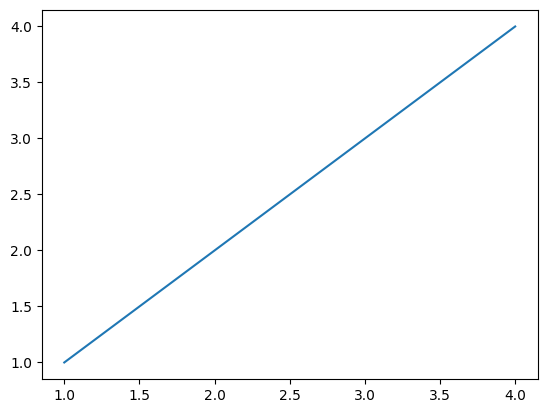

In [10]:
# import matplotlib.pyplot as plt
# from google.colab import files


# data = [1, 2, 3, 4]
# plt.plot(data, data)

# # local saving
# plt.savefig("abc.png")
# files.download("abc.png") 